In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn import metrics

%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/valid.csv')

In [3]:
# assigning X,y
y_train = train['TARGET']
X_train = train.drop(['TARGET','SK_ID_CURR'], axis=1)

In [19]:
gboost_optimized = GradientBoostingClassifier(n_estimators=200)

In [20]:
gboost_optimized.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [21]:
y_test = test['TARGET']
X_test = test.drop(['TARGET','SK_ID_CURR'], axis=1)

X_test['AMT_BAD_LOANS'] = 0
X_test['CNT_BAD_LOANS'] = 0

predictions = gboost_optimized.predict(X_test)
pred_prob = gboost_optimized.predict_proba(X_test)

In [22]:
print(classification_report(y_test, predictions))

print(confusion_matrix(y_test, predictions))
print('\n')
print(roc_auc_score(y_test, pred_prob[:,1]))

             precision    recall  f1-score   support

          0       0.92      1.00      0.96     93319
          1       0.26      0.01      0.03      8158

avg / total       0.87      0.92      0.88    101477

[[92991   328]
 [ 8044   114]]


0.7359194678027653


In [23]:
fpr, tpr, thresholds = roc_curve(y_test, pred_prob[:,1])

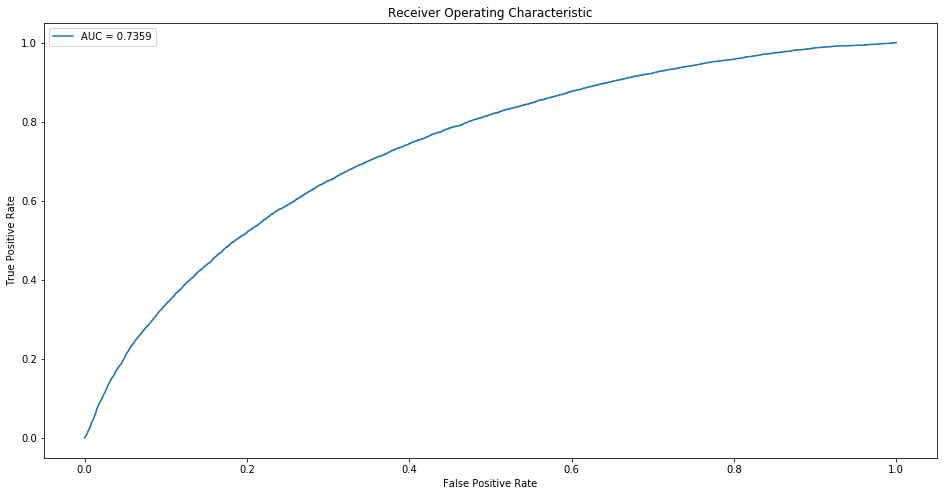

In [24]:
plt.figure(figsize=(16,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr,tpr, label='AUC = %0.4f'% roc_auc_score(y_test, pred_prob[:,1]))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='upper left')

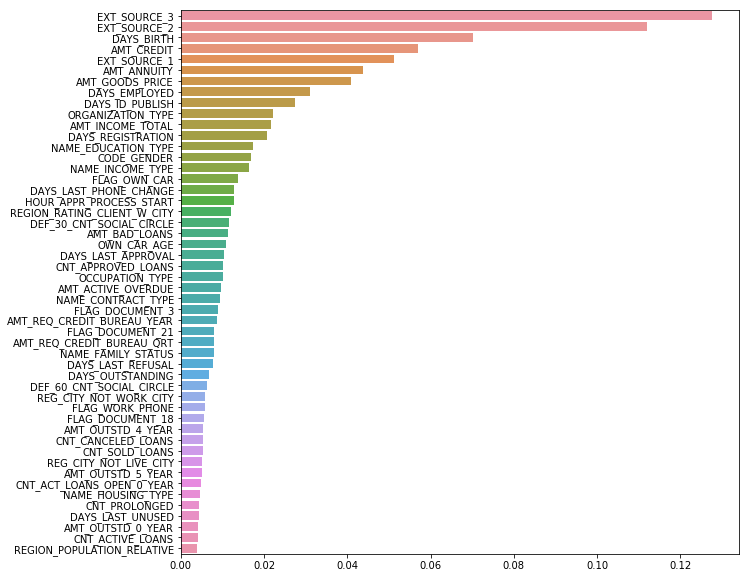

In [25]:
summary = pd.Series(gboost_optimized.feature_importances_)
summary.index = X_test.columns
summary.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(10,10))
sns.barplot(y=summary[:50].index.values, x=summary[:50].values)

In [51]:
infer_csv = pd.read_csv('../input/infer.csv')

In [52]:
X = infer_csv
X = pd.get_dummies(X.drop(['SK_ID_CURR'], axis=1), dummy_na=True)
infer_csv.set_index('SK_ID_CURR', inplace=True)

#X.loc[:,'CODE_GENDER_XNA'] = 0
#X.loc[:,'NAME_FAMILY_STATUS_Unknown'] = 0

In [53]:
probs = gboost_optimized.predict_proba(X.fillna(0))

In [54]:
submission = pd.DataFrame()
submission['TARGET'] = probs[:,1]
submission.index = infer_csv.index

In [55]:
submission.to_csv('gboost-optimized-rev-3.csv')